In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices()) 
print(tf.test.is_built_with_cuda())
# import sys
# sys.maxsize > 2**32 
# it should display True in case of 64bit and False in case of 32bit

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [ ]:
# drive.mount('/content/gdrive',force_remount=True)
# !pwd

***Data Labelling and Gathering Videos***

In [153]:
import cv2
import numpy as np
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

mouthcascade=cv2.CascadeClassifier('mouth.xml')

def get_best_pix(mouth):
  # if len(mouth)<3:
  #   return mouth[0]
  # else:
  #   return mouth[np.argmin([abs(eachmouth[0]-np.mean([q[0] for q in mouth[1:-1]])) for eachmouth in mouth[1:-1]])+1]
  return max(mouth, key=lambda sublist: sublist[1])


# eachvidfile="s1/urdu_fyp/urdu_fyp14.mp4"
# if eachvidfile=="s1/urdu_fyp/urdu_fyp14.mp4":
def get_lips(eachvidfile):
  start_time=0
  vid=cv2.VideoCapture(eachvidfile)
  frames=int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  fps = int(vid.get(cv2.CAP_PROP_FPS))
  # vidimages=[]
  last_valid_frame=0
  valid_frame_length=0
  # portions=[]#for frames as input vector
  # start_of_portion=0#for getting video for transcribing thru whisper
  portion_flag=True
  vidpart=1
  newfilename=eachvidfile.split('\\')[-1].split('.')[0]
  last_accepted_wrong_frame=-10

  for frame_count in range(frames):
    if frame_count % 50 == 0:
      print(f"{frame_count} frames passed")

    ret,frame=vid.read()

    # if frame_count % 2 == 0:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mouth=mouthcascade.detectMultiScale(frame,1.5,10)
    
    if len(mouth)!=0:
      mouth=get_best_pix(mouth)
      # vidimages.append(frame[mouth[1]:mouth[1]+mouth[3],mouth[0]:mouth[0]+mouth[2]])
      if portion_flag==True:
        start_time=frame_count/fps
        last_valid_frame=frame_count
        # start_of_portion=frame_count
        portion_flag=False

    elif len(mouth)==0:

      # add frames to lips frames where lips not detected to allow margin of error by haarcascade
      if frame_count-1==last_valid_frame and frame_count-last_accepted_wrong_frame>10: #set the value for last_accepted_wrong_frame
        last_accepted_wrong_frame=frame_count
        
      if frame_count-last_accepted_wrong_frame<10:
        continue

      if portion_flag==False:

        # if frame_count-start_of_portion>=85:
        #   portions.append((start_of_portion,frame_count-1))

        valid_frame_length=frame_count-last_valid_frame
        # print(f"frame length = {valid_frame_length}")
        if valid_frame_length>=150: #not 85 to better grab the context of urdu and get reasonable length videos
          print(f"{vidpart} video completed with frame length : {valid_frame_length}")
          ffmpeg_extract_subclip(f"{eachvidfile}", start_time,frame_count/fps, targetname=f"urdu_data/s1_2/vid/{newfilename}_part{vidpart}.mp4")
          vidpart+=1
          print(f"time of portion from {start_time} to {frame_count/fps}")
        portion_flag=True
  print("a video ended")

In [16]:
from moviepy.editor import VideoFileClip
from pydub import AudioSegment
from openai import OpenAI
import os 
from .config import openai_keys
client = OpenAI(api_key=openai_keys.API_KEY)

def make_transcript(each_file_name):
  alignment_num=each_file_name.split('/')[-1].split('.')[0]
  if os.path.exists(f'urdu_data/alignments/{alignment_num}.txt'):
     return
  
  audio_file = open(each_file_name, "rb")
  transcript = client.audio.transcriptions.create(
    model="whisper-1", 
    file=audio_file, 
    response_format="text",
    language="ur"
  )

  # write each word into newline 
  transcript=transcript.split(' ')

  # write to txt files
  with open(f'urdu_data/alignments/{alignment_num}.txt','w',encoding="utf-8") as f:
      for each_word in transcript:
          f.write(each_word+'\n')


def convert_mp4_to_wav(each_file_name):
    input_video = each_file_name
    newfilename=each_file_name.split('\\')[-1].split('.')[0]
    output_wav = f"urdu_data/s1_2/aud/{newfilename}.wav"
    if os.path.exists(output_wav) is False:
      video_clip = VideoFileClip(input_video)
      audio_clip = video_clip.audio
      audio_clip.write_audiofile(output_wav, codec='pcm_s16le', bitrate='16k', ffmpeg_params=["-ac", "1"])
    make_transcript(output_wav)

### <b>Getting short versions from each video 

In [485]:
import dlib
import numpy as np

landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# get faces and facial landmarks
def detect_faces(frame,face):
    face=dlib.rectangle(left=face[0], top=face[1], right=face[0] + face[2], bottom=face[1] + face[3])
    landmarks = landmark_predictor(frame, face)
    return landmarks

def check_mouth_move(frames, allmouths, allfaces, onemouth: bool):

    total_dist=np.zeros(len(allmouths[0]))
    prev_mouth_positions =[each_landmarks.part(i) for i in range(48, 68) for each_landmarks in [detect_faces(frames[0],face_in_firstframe) for face_in_firstframe in allfaces[0]]]
    prev_mouth_positions=[[p.x, p.y] for p in prev_mouth_positions]

    for index,faces_in_frame in enumerate(allfaces[1:]): #work with index+1 in loop
        
        landmarks = [detect_faces(frames[index+1],eachface) for eachface in faces_in_frame]  #get all landmarks of faces in current frame
        
        mouth_points = [each_landmarks.part(i) for i in range(48, 68) for each_landmarks in landmarks]  # Extract points corresponding to the mouth region
        mouth_points = [[p.x, p.y] for p in mouth_points]

        result=np.abs(np.subtract(mouth_points,prev_mouth_positions))
        result=np.sum([np.sum(result[:,0]),np.sum(result[:,1])])
        # print(result)
        total_dist=np.add(total_dist,result)  # Calculate the distance of movement of each mouth landmark
        # print(total_dist)
        prev_mouth_positions=mouth_points
        
    correct_mouth_index = np.argmax(total_dist)
    correct_mouth = [each_frame_mouths[correct_mouth_index] for each_frame_mouths in allmouths]
    # return total_dist if onemouth else correct_mouth
    return correct_mouth

In [585]:
import dlib
import numpy as np
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")


def make_mouth_face_samenum(faces,mouths): #for only choosing the mouths which are relevant the faces on the frame
    newmouths=[]
    reserve=[]
    for eachface in faces:
        min=999
        for eachmouth in mouths:
            diff=abs(eachface[0]-eachmouth[0])+abs(eachface[1]-eachmouth[1])
            if (diff)<min:
                reserve=eachmouth
                min=diff
        newmouths.append(reserve)
    return newmouths 

def get_valid_faces(getfaces:list): #seperate the faces and mouths if there are more than one out of duplicate detections of same ones 
  LIP_THRES=200
  faces=getfaces.copy()
  index = 0
  while index < len(faces):
      count = 0
      while count < len(faces):
          if count != index:  #[[1103, 385, 84, 51], [1080, 375, 127, 76], [33, 603, 84, 51], [1142, 256, 84, 51], [1020, 253, 127, 76]]
              if abs(faces[index][0] - faces[count][0]) < LIP_THRES or abs(faces[index][1] - faces[count][1]) < LIP_THRES:
                  if faces[index][1] > faces[count][1]:
                      _ = faces.pop(count)
                  else:
                      _ = faces.pop(index)
                  # Reset the inner loop since the list has been modified
                  count = 0
                  continue
          count += 1
      index += 1
  return faces  


In [889]:
import numpy as np
import cv2

def create_final_vids(each_file_nameonly):
    facecascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    multiple_face_frames=[]
    justmouths=[]
    allframes=[]
    vid=cv2.VideoCapture(f"urdu_data/s1_2/vid/{each_file_nameonly}.mp4")
    num_of_frames=int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

    print(num_of_frames)
    last_mouth=[]
    last_valid_frame=0
    for frame_num in range(num_of_frames-1):
        ret,frame=vid.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face=facecascade.detectMultiScale(frame,1.3,5)
        face=face.tolist()
        mouth=mouthcascade.detectMultiScale(frame,1.5,10)
        mouth=mouth.tolist()

        if len(mouth)==0:
            mouth=last_mouth
            if frame_num-last_valid_frame>=3: #checking frames where no mouths detected
                break
        else:
            last_valid_frame=frame_num  
            
    # for use with facecascade
        allframes.append(frame)
        # check if more than 1 face in one frame
        if (np.max([np.max([np.array(each_first_element)[0] for each_first_element in mouth]) -
            np.min([np.array(each_first_element)[0] for each_first_element in mouth]),
            np.max([np.array(each_first_element)[1] for each_first_element in mouth]) -
            np.min([np.array(each_first_element)[1] for each_first_element in mouth])]) < 300): # cuz many detection of lips on one face aswell
            mouth=[get_best_pix(mouth)] #one face in one frame found
            
        else:
            multiple_face_frames.append(frame_num) #store frames where multiple mouths detected
        
        justmouths.append(mouth)     #if multiple lips but no multiple face then store lips in nested list
                            
        last_mouth=mouth  #cover frames where no detection for error margin 
      
     

    # CHECKING MULTIPLE MOUTHS WHICH ONE IS TALKING
    if multiple_face_frames:
        temp={'temp_mouths':[],'temp_faces':[],'frames_indexes':[]}
        last_multiple_frame=multiple_face_frames[0]
        face_count=facecascade.detectMultiScale(allframes[last_multiple_frame],1.3,5)
        last_face_num=len(face_count)

    for outerframe_index in multiple_face_frames:    #[[1],  [11],[12],[13],[16],  [45],[46]] 11-16 just 2 faces
                                                    #[[1],  [11],[12],  [13],[16],  [45],[46]] 11-12 13-16 2 then 4 faces
        # check out of multiple mouth which one is moving
        faces_detected=facecascade.detectMultiScale(allframes[outerframe_index],1.3,5)
        # print(f"at frame::{outerframe_index} :: mouths::{justmouths[outerframe_index]}")
        
        faces=get_valid_faces(faces_detected.tolist())

        # if outerframe_index==45:
        #     print(f"faces {len(faces)}")
        #     print(f"mouths b4 get_valid_faces {justmouths[outerframe_index]}")
        mouths=get_valid_faces(justmouths[outerframe_index]) # same func used for valid mouths as well 
        
        # make sure same num of faces and mouths
        mouths=make_mouth_face_samenum(faces,mouths)

        
    #catch continous frames with same num of many mouths with error margin of 5 frames/1secs
        justmouths = justmouths[:outerframe_index] +[mouths] +justmouths[outerframe_index+1:]
        if abs(len(faces)-last_face_num)<1:   
            temp['temp_mouths'].append(mouths)
            temp['temp_faces'].append(faces)
            temp['frames_indexes'].append(outerframe_index)
            # print(f"{temp['temp_mouths']}\n")
        else:
            correct_mouths=check_mouth_move(frames=allframes[temp['frames_indexes'][0]:temp['frames_indexes'][-1]+1],allmouths=temp['temp_mouths'],allfaces=temp['temp_faces'],onemouth=False)  # get only pixels of mouth that is moving
            
            # # add mouth pixels to justmouths
            for indx,eachcorrmouth in enumerate(correct_mouths):
                justmouths = justmouths[:temp['frames_indexes'][0]+indx] +[[eachcorrmouth]] +justmouths[temp['frames_indexes'][0]+indx+1:]

            # print('num of face changes')
            temp['temp_faces']=[faces]
            temp['temp_mouths']=[mouths]
            temp['frames_indexes']=[outerframe_index]
            
        last_multiple_frame=outerframe_index
        last_face_num=len(faces)
    print(len(justmouths))

# create_final_vids('urdu_fyp14_part2')

In [879]:
len(justmouths)

138

In [880]:
if multiple_face_frames:
    temp={'temp_mouths':[],'temp_faces':[],'frames_indexes':[]}
    last_multiple_frame=multiple_face_frames[0]
    face_count=facecascade.detectMultiScale(allframes[last_multiple_frame],1.3,5)
    last_face_num=len(face_count)

for outerframe_index in multiple_face_frames:    #[[1],  [11],[12],[13],[16],  [45],[46]] 11-16 just 2 faces
                                                #[[1],  [11],[12],  [13],[16],  [45],[46]] 11-12 13-16 2 then 4 faces
# check out of multiple mouth which one is moving
    faces_detected=facecascade.detectMultiScale(allframes[outerframe_index],1.3,5)
    # print(f"at frame::{outerframe_index} :: mouths::{justmouths[outerframe_index]}")
    
    faces=get_valid_faces(faces_detected.tolist())

    # if outerframe_index==45:
    #     print(f"faces {len(faces)}")
    #     print(f"mouths b4 get_valid_faces {justmouths[outerframe_index]}")
    mouths=get_valid_faces(justmouths[outerframe_index]) # same func used for valid mouths as well 
    
    # if outerframe_index==45:
    #     print(f"faces {len(faces)}")
    #     print(f"mouths b4 make_mouth_face_samenum{mouths}")

    # make sure same num of faces and mouths
    mouths=make_mouth_face_samenum(faces,mouths)

    # if outerframe_index==45:
    #     print(f"faces {len(faces)}")
    #     print(f"mouths after make_mouth_face_samenum{mouths}")
    print(f'check ::{outerframe_index}\n')
    print(f"faces {len(faces)}")
    print(f"mouths {mouths}")
    
#catch continous frames with same num of many mouths with error margin of 5 frames/1secs
    justmouths = justmouths[:outerframe_index] +[mouths] +justmouths[outerframe_index+1:]
    if abs(len(faces)-last_face_num)<1:   
        temp['temp_mouths'].append(mouths)
        temp['temp_faces'].append(faces)
        temp['frames_indexes'].append(outerframe_index)
        # print(f"{temp['temp_mouths']}\n")
    else:
        # print('asdasdasd')
        # print(temp['frames_indexes'][-1])
        # print(len(allframes[temp['frames_indexes'][0]:temp['frames_indexes'][-1]+1]))
        correct_mouths=check_mouth_move(frames=allframes[temp['frames_indexes'][0]:temp['frames_indexes'][-1]+1],allmouths=temp['temp_mouths'],allfaces=temp['temp_faces'],onemouth=False)  # get only pixels of mouth that is moving
        print(f"correct mouth in past {len(temp['temp_mouths'])} frames ::{correct_mouths}")
        
        # # add mouth pixels to justmouths
        for indx,eachcorrmouth in enumerate(correct_mouths):
            justmouths = justmouths[:temp['frames_indexes'][0]+indx] +[[eachcorrmouth]] +justmouths[temp['frames_indexes'][0]+indx+1:]

        print('num of face changes')
        temp['temp_faces']=[faces]
        temp['temp_mouths']=[mouths]
        temp['frames_indexes']=[outerframe_index]
        
    last_multiple_frame=outerframe_index
    last_face_num=len(faces)


check ::14

faces 1
mouths [[1103, 385, 84, 51]]
check ::15

faces 1
mouths [[1093, 379, 127, 76]]
check ::16

faces 1
mouths [[1102, 375, 127, 76]]
check ::17

faces 1
mouths [[1170, 260, 84, 51]]
check ::18

faces 2
mouths [[1146, 376, 84, 51], [195, 603, 84, 51]]
correct mouth in past 4 frames ::[[1103, 385, 84, 51], [1093, 379, 127, 76], [1102, 375, 127, 76], [1170, 260, 84, 51]]
num of face changes
check ::19

faces 1
mouths [[1195, 256, 84, 51]]
correct mouth in past 1 frames ::[[1146, 376, 84, 51]]
num of face changes
check ::20

faces 1
mouths [[1204, 257, 84, 51]]
check ::21

faces 1
mouths [[1213, 255, 84, 51]]
check ::22

faces 1
mouths [[1185, 375, 84, 51]]
check ::23

faces 1
mouths [[1164, 369, 127, 76]]
check ::24

faces 1
mouths [[1227, 254, 84, 51]]
check ::25

faces 1
mouths [[1229, 254, 84, 51]]
check ::26

faces 1
mouths [[1231, 256, 84, 51]]
check ::27

faces 1
mouths [[1234, 259, 84, 51]]
check ::28

faces 1
mouths [[1235, 262, 84, 51]]
check ::29

faces 1
mouths 

In [882]:
outerframe_index
# temp['frames_indexes']
# justmouths[outerframe_index]
# njustmouths=justmouths[2:6]
# new=njustmouths[:1]+[[[1,2,3,5]]]+njustmouths[2:]
# new
len(justmouths)
# temp['frames_indexes']
# multiple_face_frames[54:]  #20-78

138

In [621]:
def detect_faces(frame,face):
    face=dlib.rectangle(left=face[0], top=face[1], right=face[0] + face[2], bottom=face[1] + face[3])
    landmarks = landmark_predictor(frame, face)
    return landmarks

frames=temp['frames']
allmouths=temp['temp_mouths']
allfaces=temp['temp_faces']
onemouth=True

# for mouths_in_firstframe in allmouths[0]:
total_dist=np.zeros(len(allmouths[0]))

# print(total_dist)
# face=face[0]
# face=dlib.rectangle(left=face[0], top=face[1], right=face[0] + face[2], bottom=face[1] + face[3])
# landmarks = landmark_predictor(frame, face)

# for face_in_firstframe in allfaces[0]:
#     print(face_in_firstframe)

# Store the current mouth position from prev frame for comparison in current frame
prev_mouth_positions =[each_landmarks.part(i) for i in range(48, 68) for each_landmarks in [detect_faces(frames[0],face_in_firstframe) for face_in_firstframe in allfaces[0]]]

prev_mouth_positions=[[p.x, p.y] for p in prev_mouth_positions]

for index,faces_in_frame in enumerate(allfaces[1:]): #work with index+1 in loop
    
    landmarks = [detect_faces(frames[index+1],eachface) for eachface in faces_in_frame]  #get all landmarks of faces in current frame
    
    mouth_points = [each_landmarks.part(i) for i in range(48, 68) for each_landmarks in landmarks]  # Extract points corresponding to the mouth region
    mouth_points = [[p.x, p.y] for p in mouth_points]

    result=np.abs(np.subtract(mouth_points,prev_mouth_positions))
    result=np.sum([np.sum(result[:,0]),np.sum(result[:,1])])
    # print(result)
    total_dist=np.add(total_dist,result)  # Calculate the distance of movement of each mouth landmark
    # print(total_dist)
    prev_mouth_positions=mouth_points
    
correct_mouth_index = np.argmax(total_dist)
correct_mouth = [each_frame_mouths[correct_mouth_index] for each_frame_mouths in allmouths]
print(total_dist if onemouth else correct_mouth)

RuntimeError: Unsupported image type, must be 8bit gray or RGB image.

In [401]:
import numpy as np

# Example matrices
matrix1 = np.array([[1, 2], [3, 4]])
matrix2 = np.array([[5, 6], [7, 8]])

# Subtract matrices using np.subtract
result = np.abs(np.subtract(matrix1, matrix2))
# result=np.sum(result)
# result=np.add(result[0],result[1])
print(result)

[[4 4]
 [4 4]]


### Threading

In [17]:
# implementing functions to get long lips videos
import glob
from concurrent.futures import ThreadPoolExecutor
import os

def main():

    # find all full-fledged youtube vids and start breaking

    main_vid_files=[eachvidfile for eachvidfile in glob.glob('urdu_data/s1/*.mp4')] 
    
    #check if parts of a vid file are already made then remove it from list supplied to function 
    for eachpath in main_vid_files:
        npath=eachpath.split('\\')[-1].split('.')[0]
        if os.path.exists(f"urdu_data/s1_2/vid/{npath}_part1.mp4"):
            main_vid_files.remove(eachpath) 
        
    if main_vid_files:    
        with ThreadPoolExecutor(max_workers=len(main_vid_files)) as exe:
            # Maps the method 'cube' with a list of values.
            _ = exe.map(get_lips,main_vid_files)
    
    
    # find broken vids and make auds and transcripts
    formed_vid_files=[eachvidfile for eachvidfile in glob.glob('urdu_data/s1_2/vid/*.mp4')]

    for eachformedpath in formed_vid_files:
        npath=eachformedpath.split('\\')[-1].split('.')[0]
        for filecount in range(len(formed_vid_files)):
            if os.path.exists(f"urdu_data/s1_2/vid/{npath}_part{filecount}.mp4"):
                formed_vid_files.remove(eachformedpath) 
    if formed_vid_files:
        for count in range(0, len(formed_vid_files), 5):
            with ThreadPoolExecutor(max_workers=5) as exe:
                # Maps the method 'cube' with a list of values.
                _ = exe.map(convert_mp4_to_wav,formed_vid_files[count:count+5])
    
    # print(formed_vid_files)
if __name__ == "__main__":
    main()

15
[[ 195  295   72   44]
 [ 277  299   60   36]
 [1400  825   55   33]
 [ 725  305   82   50]
 [ 640  290  173  103]
 [1093  290  157   94]
 [1581  345   70   42]
 [1337  358   81   49]
 [ 235  362   78   47]
 [1142  368   70   42]
 [ 685  371   72   44]
 [ 208   89   62   38]
 [1051  273  265  159]
 [ 748   89   71   43]
 [1130  396  105   63]]
then
[[ 195  295   72   44]
 [ 277  299   60   36]
 [1400  825   55   33]
 [ 725  305   82   50]
 [ 640  290  173  103]
 [1093  290  157   94]
 [1581  345   70   42]
 [1337  358   81   49]
 [ 235  362   78   47]
 [1142  368   70   42]
 [ 685  371   72   44]
 [ 208   89   62   38]
 [1051  273  265  159]
 [ 748   89   71   43]
 [1130  396  105   63]]


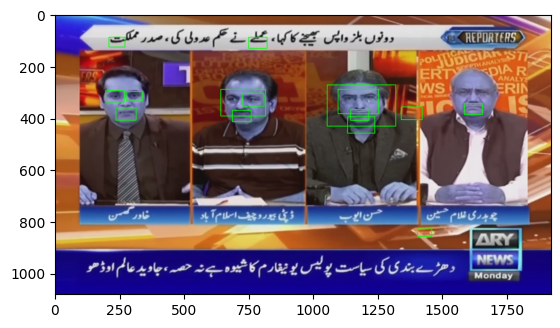

In [8]:
eachvidfile="urdu_data/s1_2/vid/urdu_fyp14_part2.mp4"
import matplotlib.pyplot as plt
import numpy as np
import cv2
from numba import jit, cuda
import warnings
warnings.filterwarnings('ignore')


def get_best_pix(mouth):
  # print(f"mouth is :\n{mouth}\n")
  return max(mouth, key=lambda sublist: (sublist[1]))
# if eachvidfile=="s1/urdu_fyp/urdu_fyp14.mp4":
  # start_time=0
mouthcascade=cv2.CascadeClassifier('mouth.xml')

# @jit(target_backend='cuda') 
def func():
  vid=cv2.VideoCapture('urdu_data/s1_2/vid/urdu_fyp14_part17.mp4')
  n=0

  while(True):
    ret,frame=vid.read()
    # if n>=1100:
    # if len(mouth)!=0:
    #   cmouth+=1
    
    nframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mouth=mouthcascade.detectMultiScale(nframe,1.3,5)

    # if len(mouth)==0:
    #   print('no mouths') 
    #   continue
    # else:

    for (x, y, w, h) in mouth:
      cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    if n==5:  
      print(len(mouth))
      print(mouth)
      print('then')
      # print(np.max([np.array(each_first_element)[0] for each_first_element in mouth])-np.min([np.array(each_first_element)[0] for each_first_element in mouth],[np.array(each_first_element)[1] for each_first_element in mouth])-np.min([np.array(each_first_element)[1] for each_first_element in mouth]))
      # mouth=get_best_pix(mouth)
      print(mouth)
      # cv2.rectangle(frame, (mouth[0], mouth[1]), (mouth[0]+mouth[2], mouth[1]+mouth[3]), (255, 0, 0), 3)
      plt.imshow(frame)
      break

    n+=1

if __name__=="__main__":
  func()

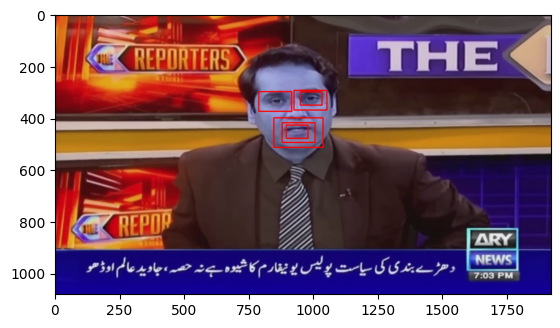

In [31]:
for (x, y, w, h) in mouth:
        # Draw a rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 3)
plt.imshow(frame)

In [26]:
# !pip install git+https://github.com/openai/whisper.git

'/device:GPU:0'

### <b>Threading

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np


# @jit(target_backend="cuda")
def func2(a):
    for i in range(1000000):
        a[i] += 1
    return a

# @jit(target_backend="cuda")
def main():
    result =[]
    a = np.ones(1000000, dtype=np.float64)

    values = [a for _ in range(50)]
    with ThreadPoolExecutor(max_workers=50) as exe:
        # Maps the method 'cube' with a list of values.
        result = exe.map(func2,values)
     
    for r in result:
      print(r)

if __name__ == "__main__":
    main()

### ***Data Augmentation by adding voice and making seperate files that are directly input to the model.***

In [ ]:
# !pip install -U augly[video]

# !sudo apt-get install python3-magic
# !sudo add-apt-repository ppa:jonathonf/ffmpeg-4
# !apt install ffmpeg
# !pip install --upgrade pillow==6.2.2
# !ls
# !pip show augly

In [ ]:
import os
import cv2
import tensorflow as tf
import augly.image as imaugs
from IPython.display import display
import PIL
import numpy as np

# remove already available files
for firstrun in range(11,14):
  for secondrun in range(2):
    prev_file=f's1/urdu_fyp/urdu_fyp{firstrun}_{secondrun}.mp4'
    if os.path.exists(prev_file):
      os.remove(prev_file)



def simple_pipeline(image,secondrun:int):
    secondrun+=1
    image = imaugs.random_noise(image, mean=-0.02*secondrun, var=0.01*secondrun)
    image = imaugs.skew(image, skew_factor=0.1*secondrun)
    image = imaugs.scale(image, factor = secondrun*0.5)
    # image = imaugs.rotate(image, degrees = secondrun*8)
    # image = imaugs.hflip(image) if secondrun%2==0 else imaugs.vflip(image)
    return image

# create augmented video files
for firstrun in range(11,14):
  for secondrun in range(2):
    yinit=0
    yfinal=0
    vidimages=[]
    filepath=f"s1/urdu_fyp/urdu_fyp{firstrun}.mp4"
    vid=cv2.VideoCapture(filepath)


    while (True):
      ret,frame=vid.read()
      if not ret:
        break
      newfilepath=f"s1/urdu_fyp/urdu_fyp{firstrun}_{yinit}.jpeg"
      cv2.imwrite(newfilepath,frame)
      yinit+=1
    print("yinit = "+str(yinit))

    print("secondrun is "+str(secondrun))
    while(True):
      if yfinal==yinit:
        break
      inputfile=f"s1/urdu_fyp/urdu_fyp{firstrun}_{yfinal}.jpeg"
      yfinal+=1
      image=simple_pipeline(inputfile,secondrun)
      vidimages.append(image)
    # display(vidimages[51])

    # np.asarray(vidimages[50]).shape
    frameSize = np.asarray(vidimages[10]).shape
    frameSize=[frameSize[0],frameSize[1]]
    out = cv2.VideoWriter(f"s1/urdu_fyp/urdu_fyp{firstrun}_{secondrun}.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 20, frameSize=frameSize)
    for images in vidimages:
        out.write(np.asarray(images))
    out.release()


    for y in range(yinit):
      os.remove(f"s1/urdu_fyp/urdu_fyp{firstrun}_{y}.jpeg")
    if not (os.path.exists(f"alignments/urdu_fyp{firstrun}_{secondrun}.txt")):
      f=open(f"alignments/urdu_fyp{firstrun}_{secondrun}.txt",'x',encoding="utf8")
      f.write("میرا\nنام\nجان\nہے\n۔")
      # f.write("asd")

yinit = 87
secondrun is 0
yinit = 87
secondrun is 1
yinit = 64
secondrun is 0
yinit = 64
secondrun is 1
yinit = 88
secondrun is 0
yinit = 88
secondrun is 1


In [ ]:
# import numpy as np
# import cv2
# x=11
# ynew=0
# # np.asarray(vidimages[50]).shape
# frameSize = np.asarray(vidimages[50]).shape
# frameSize=[frameSize[0],frameSize[1]]
# out = cv2.VideoWriter(f"s1/urdu_fyp/urdu_fyp{x}_{ynew}.mp4",cv2.VideoWriter_fourcc(*'DIVX'), 20, frameSize=frameSize)
# for images in vidimages:
#     out.write(np.asarray(images))
# out.release()

In [1]:
import cv2
import tensorflow as tf
import re
test="ا ب پ ت ٹ ث ج چ ح خ د ڈ ذ ر ڑ ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن ں و ہ ھ ء ی ے"
vocab=[x for x in re.findall(r'[\u0600-\u06ff]',test)]
char_to_num_layer=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
num_to_char_layer=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="",invert=True)

In [2]:
import cv2
import numpy as np

# def frames(filepath:str)->list[float]:
def frames(filepath:str)->list[float]:
  mouthcascade=cv2.CascadeClassifier('mouth.xml')
  frames=[]
  vid=cv2.VideoCapture(filepath)
  current_frames=int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  print(current_frames)
  total_frames=current_frames-60
  # return int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

  for eachframe in range(current_frames):
    ret,frame=vid.read()
    # to make each video of 75 frames
    if eachframe%2==1 and total_frames!=0:
      total_frames-=1
      continue

    frame=tf.image.rgb_to_grayscale(frame)
    mouth=mouthcascade.detectMultiScale(frame.numpy(),1.3,5,minSize=(100,180),maxSize=(180,300))
    for (x,y,w,h) in mouth:
      frames.append(frame[y:y+h,x:x+w])
      break
    # print(frame)
  vid.release()

  mean=tf.math.reduce_mean(frames)
  std=tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames-mean),tf.float32)/std

def alignments(filepath:str)->list[str]:
  text=[]
  with open(filepath,'r') as f:
    lines=f.readlines()
    for line in lines:
      # line=line.split()
      if line[:] !="۔":
        for each_harf in line:
          if each_harf=="\n":
            continue
          text.append(each_harf)
  return text

def feeddata(filepath):
  filepath=bytes.decode(filepath.numpy())
  # print(filepath)
  filename=filepath[12:].split('.')[-2]
  # return filename
  myalignments=char_to_num_layer(alignments("alignments/"+ filename + ".txt"))
  myframes=frames("s1/urdu_fyp/"+filename+".mp4")
  # return myframes,myalignments
  return myframes
# !pwd

# frames[0]

In [ ]:
# %cd gdrive/MyDrive/datasets/urdu_dataset
# !ls
# data.next()
# import cv2
# import tensorflow as tf
# import re

# text=[]
# with open("alignments/urdu_fyp1.txt",'r') as f:
#   lines=f.readlines()
#   for line in lines:
#     # line=line.split()
#     if line[:] !="۔":
#       for each_harf in line:
#         if each_harf=="\n":
#           continue
#         text.append(each_harf)
# print(text)

# vocab=[x for x in re.findall(r'[\u0600-\u06ff]',test)]
# char_to_num_layer=tf.keras.layers.StringLookup(vocabulary=vocab,oov_token="")
# print(char_to_num_layer.vocabulary_size())

40


In [ ]:
import tensorflow as tf
data=tf.data.Dataset.list_files("s1/urdu_fyp/urdu_fyp13_1.mp4",shuffle=250)
data=data.map(lambda x : tf.py_function(feeddata,[x],(tf.float32)))
# data=data.map(lambda x : tf.py_function(feeddata,[x],(tf.float32,tf.int64))).padded_batch(2,padded_shapes=([60,None,None,None],[40])).prefetch(tf.data.AUTOTUNE)
# data
for x in data:
  print(x.shape)
  break

# data=data.map(lambda x : tf.py_function(feeddata,[x],(tf.float32,tf.int64))).padded_batch(2,padded_shapes=([75,None,None,None],[40])).prefetch(tf.data.AUTOTUNE)
# frames,alignment=data.as_numpy_iterator().next()
# len(frames)

/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data
88
(0,)


In [ ]:
for x in data:
  print(x.shape)
  break

/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data
(0,)


In [ ]:
# for x in data:
#   filepath=bytes.decode(x.numpy())
#   filename=filepath[12:].split('.')[-2]
#   print(f"{filename}\n")
  # filepath=bytes.decode(x.numpy())
  # filename=filepath[12:].split('.')[-2]
  # print(filename)
  # break

/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data
tf.Tensor([], shape=(0,), dtype=float32)


In [ ]:
# import imageio
# data
# test=data.as_numpy_iterator()
# val=test.next()
# val
# val[0][0][0].shape
# imageio.mimsave("./animation.gif",val[0][1],fps=10)

In [3]:
from keras.api._v2.keras.layers import Flatten
train=data.take(5)
test=data.skip(5)
# len(test)
mymodel=tf.keras.models.Sequential()
mymodel.add(tf.keras.layers.Conv3D(64,3,input_shape=(60,94,157,1),activation="relu",padding="same"))
mymodel.add(tf.keras.layers.MaxPool3D((1,2,2)))

mymodel.add(tf.keras.layers.Conv3D(64,3,activation="relu",padding="same"))
mymodel.add(tf.keras.layers.MaxPool3D((1,2,2)))

mymodel.add(tf.keras.layers.Conv3D(32,3,activation="relu",padding="same"))
mymodel.add(tf.keras.layers.MaxPool3D((1,2,2)))

mymodel.add(tf.keras.layers.TimeDistributed(Flatten()))

mymodel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,kernel_initializer="orthogonal",return_sequences=True)))
mymodel.add(tf.keras.layers.Dropout(0.25))

mymodel.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,kernel_initializer="orthogonal",return_sequences=True)))
mymodel.add(tf.keras.layers.Dropout(0.25))

mymodel.add(tf.keras.layers.Dense(char_to_num_layer.vocabulary_size()+1,kernel_initializer="he_normal",activation="softmax"))

NameError: name 'data' is not defined

In [ ]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 60, 94, 157, 64)   1792      
                                                                 
 max_pooling3d (MaxPooling3  (None, 60, 47, 78, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 60, 47, 78, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 60, 23, 39, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 60, 23, 39, 32)    55328     
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 60, 11, 19, 32)    0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend
import os

def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    # input_length = tf.cast(input_length * tf.ones(shape=(batch_len, 1)),dtype="int64")
    # label_length = tf.cast(label_length * tf.ones(shape=(batch_len, 1)),dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(batch_len)
    # print("Asd")
    # print( input_length, label_length)
    return loss

class exmpl(tf.keras.callbacks.Callback):
  def __init__(self,dataset) -> None:
    self.dataset=dataset.as_numpy_iterator()
  def on_epoch_end(self,epoch, logs=None):
    one=self.dataset.next()
    ypred=mymodel.predict(one[0])
    decoded=backend.ctc_decode(ypred,[60],greedy=False)[0][0].numpy()
    # for x in range(len(ypred)):
      # print("original= " + tf.strings.reduce_join(''+ vocab[word] for word in one[1][x]).numpy().decode("utf-8"))
      # print("predicted= " + tf.strings.reduce_join(''+ vocab[word] for word in decoded[x]).numpy().decode("utf-8"))
    print("~"*20)


In [ ]:
def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
# tensor = tf.constant([[1, 2], [3, 4], [5, 6]])
# dataset = tf.data.Dataset.from_tensor_slices(tensor)
# data=dataset.as_numpy_iterator()
# data1=data.next()
# data2=data.next()
# data2
# vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
# char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# print(char_to_num.vocabulary_size())

In [ ]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=CTCLoss)
# modelchkpnt=ModelCheckpoint(os.path.join("models","checkpoints"))
schedulerchkpnt=LearningRateScheduler(scheduler)
# exple=exmpl(test)
mymodel.fit(train,validation_data=test,epochs=1,callbacks=[schedulerchkpnt])

Epoch 1/9
/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data
/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data


InvalidArgumentError: ignored

/content/gdrive/MyDrive/datasets/urdu_data/libraries_used
/content/gdrive/MyDrive/datasets/urdu_data
